# Assignment 9: CNN with CIFAR-10

## Introduction:
In this coursework, you will gain practical experience using Convolutional Neural Networks (CNNs) for image classification. Specifically, you'll use two widely recognized pre-trained architectures—VGG16 and ResNet18—to classify images from the CIFAR-10 dataset. CIFAR-10 consists of 60,000 color images (32x32 pixels), evenly divided across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

You'll apply transfer learning by adapting these pre-trained models to the CIFAR-10 dataset, train and evaluate both models, compare their performance.

## Objectives:
- Understand and implement transfer learning.
- Train CNN models using pre-trained architectures.
- Unfreeze and fine-tune the final convolutional layer of each model.
- Evaluate and compare the performance of different CNN models.
- Analyze results with a confusion matrix.

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Check if GPU (CUDA) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Question 1: Dataset Setup and Exploration
1. Download and load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10`.
2. Apply model-specific transformations with data augmentation:
   - For VGG16: Use transformations from `VGG16_Weights.DEFAULT.transforms` as a base and apply additional augmentations:
       - `AutoAugment` with CIFAR10 policy
       - `RandomHorizontalFlip` (50% chance)
   - For ResNet18: Use `ResNet18_Weights.DEFAULT.transforms` similarly with the same augmentations applied.
3. Use 10% of the training and testing datasets to reduce computation time.
4. Define DataLoaders separately for each model for efficient and correct training/testing behavior. Ensure `shuffle = True` for training DataLoaders.
5. Visualize a batch of sample images from each model’s DataLoader to confirm that preprocessing and augmentations have been applied correctly.

In [4]:
# 1. Download and load the CIFAR-10 dataset
from torchvision.datasets import CIFAR10
torch.manual_seed(42)
train_data = CIFAR10(root='./data', train=True, download=True)
test_data = CIFAR10(root='./data', train=False, download=True)

In [7]:
# 2. Model-specific transformations with data augmentation
vgg_base_transform = models.VGG16_Weights.DEFAULT.transforms()
vgg_train_transform = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(p=0.5),
    vgg_base_transform
])

resnet_base_transform = models.ResNet18_Weights.DEFAULT.transforms()
resnet_train_transform = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(p=0.5),
    resnet_base_transform
])

In [8]:
# 3. # 3. Load the datasets (both train and test) for each model.
# For training datasets we use the respective augmentation transforms.
full_train_vgg = CIFAR10(root='./data', train=True, download=True, transform=vgg_train_transform)
full_train_resnet = CIFAR10(root='./data', train=True, download=True, transform=resnet_train_transform)

# For testing datasets you might typically avoid heavy augmentations.
# However, if the assignment requires the same pre-processing pipeline for both,
# we use the same transforms here. Alternatively, one could use only the base transform.
full_test_vgg = CIFAR10(root='./data', train=False, download=True, transform=vgg_train_transform)
full_test_resnet = CIFAR10(root='./data', train=False, download=True, transform=resnet_train_transform)

In [9]:
def get_subset(dataset, fraction=0.1):
    total_size = len(dataset)
    subset_size = int(total_size * fraction)
    return random_split(dataset, [subset_size, total_size - subset_size])[0]

train_vgg_subset = get_subset(full_train_vgg, fraction=0.1)
test_vgg_subset = get_subset(full_test_vgg, fraction=0.1)

train_resnet_subset = get_subset(full_train_resnet, fraction=0.1)
test_resnet_subset = get_subset(full_test_resnet, fraction=0.1)

In [10]:
# 5. Define DataLoaders for each model.
batch_size = 32

# For VGG16:
trainloader_vgg = DataLoader(train_vgg_subset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_vgg = DataLoader(test_vgg_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# For ResNet18:
trainloader_resnet = DataLoader(train_resnet_subset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_resnet = DataLoader(test_resnet_subset, batch_size=batch_size, shuffle=False, num_workers=2)

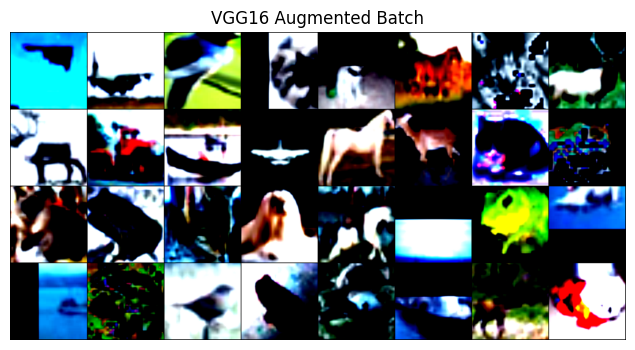

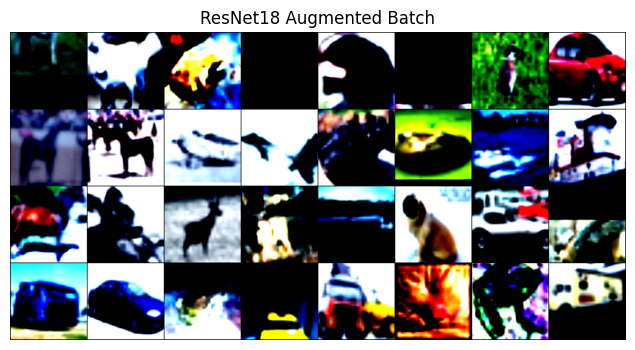

In [11]:
# 6. Visualize a batch of sample images from each model’s DataLoader.

def imshow(img, title=None):
    # Unnormalize if needed; here we assume images are in [0, 1]
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch for VGG16
dataiter_vgg = iter(trainloader_vgg)
images_vgg, labels_vgg = next(dataiter_vgg)
imshow(torchvision.utils.make_grid(images_vgg), title="VGG16 Augmented Batch")

# Get one batch for ResNet18
dataiter_resnet = iter(trainloader_resnet)
images_resnet, labels_resnet = next(dataiter_resnet)
imshow(torchvision.utils.make_grid(images_resnet), title="ResNet18 Augmented Batch")

Examine the CIFAR-10 images after applying transformations. Identify two classes you believe are most difficult for the models to distinguish and explain why.

**Written Answer:**

Birds and Planes are the classes that I believe are the most difficult for the models to distinguish because both of them have similar shapes. They have wings extended sideways and a central body with tail-like structures.

## Question 2: Model Definitions – VGG16 and ResNet18
1. Load pre-trained VGG16 and ResNet18 models from torchvision.
2. Freeze all convolutional layers initially, then unfreeze the last convolutional block in both models.
3. Modify the classifier layers to accommodate CIFAR-10 classification (10 output classes).

In [12]:
# 1. Load pre-trained models
model_vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.9MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.8MB/s]


In [13]:
# 2. Freeze all convolutional layers initially, then unfreeze the last convolutional block in both models.
for param in model_vgg.parameters():
    param.requires_grad = False

for param in model_resnet.parameters():
    param.requires_grad = False

In [14]:
# 3. Modify classifier layers for CIFAR-10 (10 classes)
num_features_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_features_vgg, 10)

num_features_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features_resnet, 10)

Explain the concept of transfer learning and its specific advantages when applied to CIFAR-10 classification using models like VGG16 and ResNet18.

- Concept of Transfer Learning
  - Feature Reuse: It learns hierarchical features, which early layers capture edges, corners, and deeper layers capture more complex shapes.
  - Reduced Training Time & Data Requirements: Pre-trained models requires much less amount of data and epochs for training.
  - Enhanced Performance: The models have weights that encode robust visual representations
- Advantages of Transfer Learning
  - Faster Training: CIFAR-10 has 50,000 training images and 10,000 test images, so using large CNNs would lead to longer training times.
  - Performance Boost: Pre-trained networks have already captured robust feature hierarchies, reducing the risk of the model getting stuck in poor local minima.
  - Efficient Fine-Tuning: We can freeze earlier layers and only fine-tune later layers.

**Written Answer:**

## Question 3: Training the Models
1. Define the loss function (Cross-Entropy Loss).
2. Initialize Adam optimizers for each model with a learning rate of 0.001.
3. Train each model separately. Train for 5 epochs, monitor loss, and ensure proper updating of model weights.

In [16]:
# 1. Define the loss function (Cross-Entropy Loss).
criterion = nn.CrossEntropyLoss()

# 2. Initialize Adam optimizers for each model with a learning rate of 0.001.
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

In [17]:
# 3. Train each model separately for 5 epochs
num_epochs = 5

print("----- Training VGG16 -----")
model_vgg.train()  # set to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader_vgg):
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_vgg.zero_grad()

        # Forward pass
        outputs = model_vgg(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer_vgg.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print average loss for this epoch
    epoch_loss = running_loss / len(trainloader_vgg)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("\n----- Training ResNet18 -----")
model_resnet.train()  # set to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader_resnet):
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer_resnet.zero_grad()

        # Forward pass
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer_resnet.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print average loss for this epoch
    epoch_loss = running_loss / len(trainloader_resnet)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

----- Training VGG16 -----
Epoch [1/5], Loss: 1.2063
Epoch [2/5], Loss: 0.9950


KeyboardInterrupt: 

Compare training behaviours of VGG16 and ResNet18. Which model trains faster and why?

**Written Answer:**

## Question 4: Model Evaluation
1. Define a function to calculate the accuracy of each model on the test set.
2. Evaluate both models separately.
3. Plot confusion matrices for each model using `sklearn.metrics.confusion_matrix` and `ConfusionMatrixDisplay`.
4. Interpret results based on model-specific accuracy and confusion matrix insights.

In [ ]:
# Evaluation & confusion matrix











Suggest two additional improvements specifically tailored for the less accurate model. Clearly explain your rationale for each suggestion.

**Written Answer:**